In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

Modeling the effect of AcCh and brain region on lipid levels is better done using normalized, species-level data than the previously used group-level data.  Moreover, including a random effect term of samples (mixed effects modeling) seems a beneficial addition.  However, analysis of residuals shows that normal linear models do not fit well in general to the group-level and species-level data.  This calls into question the results inferred previously from a fixed effects linear model fitted on group-level data. Instead, linear models with right-skewed error distribution may provide better fit and hence more credible findings.

## Data sets

The lipid species-level data contains $n_{\mathrm{species} \in \mathrm{group}}$ times more information than the group-level data previously analyzed in the present project.  Therefore, fitting models to species-level data would be advantageous.

| | lipid group-level data | lipid species-level data |
| ------------------------- | ----------- | -------------- |
| a unit of observation | a lipid group in a sample | a lipid species in a sample |
| no. data points per lipid group | $3 \times 10$ samples | $3 \times 10 \times n_{\mathrm{species} \in \mathrm{group}}$ |
| level of $\mathrm{species} \in \mathrm{group}$ assumed i.i.d? (linear model) | yes | yes |


In [2]:
fpath = '../../resources/clinical-table.csv'
clinical_data = pd.read_csv(fpath, usecols=['Patient number', 'Age at death (years)', 'PMI (hours)'], index_col='Patient number')
clinical_data = clinical_data.rename({'Age at death (years)': 'AgeAtDeath', 'PMI (hours)': 'PMI'}, axis=1)
clinical_data

,AgeAtDeath,PMI
Patient number,,
ChAc 1,51,8.0
ChAc 2,50,32.7
ChAc 3,61,12.8
ChAc 4,40,22.0
Control 1,53,25.4
Control 2,50,23.3
Control 3,57,26.4
Control 4,59,33.0
Control 5,54,19.3


In [3]:
fpath = '../../resources/demographic-data.csv'
demographic_data = pd.read_csv(fpath, index_col=0)

In [4]:
brain_regions = ['DLPFC', 'CN', 'Putamen']
brain_regions1 = ['CN', 'Putamen', 'DLPFC']

In [5]:
def to_long_format(wide_data, axis_names=['Group', 'Species', 'Region', 'Subject'], demographic_data=clinical_data):
    s = wide_data.stack(level=1).stack().rename_axis(axis_names)
    endog = s.to_frame('Level')
    exog = s.index.to_frame()
    exog['Region:Subject'] = [r + ' : ' + s for r, s in zip(exog.Region, exog.Subject)]
    exog['Dx'] = [re.sub('^(Control|ChAc).*$', '\\1', s) for s in exog.Subject]
    data = pd.concat([endog, exog], axis=1)
    data = data.astype({
        'Region': CategoricalDtype(categories=brain_regions, ordered=True),
        'Dx': CategoricalDtype(categories=['Control', 'ChAc'], ordered=True),
                       })
    demdata = demographic_data.reindex(data.index.get_level_values('Subject'))
    demdata.index = data.index
    data = pd.concat([data, demdata], axis=1)
    return(data)

In [6]:
fpath = '../../resources/lipid-data-groups.csv'
lipid_groups = pd.read_csv(fpath, header=[0, 1], index_col=0)
lipid_groups = lipid_groups.reindex(pd.MultiIndex.from_product([demographic_data.index, brain_regions]), axis=1)
std_lipid_groups = lipid_groups.apply(lambda s: (s - s.mean()) / s.std(), axis=1)
stdgroupdata = to_long_format(std_lipid_groups, ['Group', 'Region', 'Subject'])
stdgroupdata

Level Group   Region    Subject  \
Group Region  Subject                                         
FC    CN      ChAc 1    -0.520661    FC       CN     ChAc 1   
              ChAc 2    -2.466412    FC       CN     ChAc 2   
              ChAc 3     1.146440    FC       CN     ChAc 3   
              ChAc 4     1.268065    FC       CN     ChAc 4   
              Control 1  1.302206    FC       CN  Control 1   
...                           ...   ...      ...        ...   
NSer  Putamen Control 2  0.443121  NSer  Putamen  Control 2   
              Control 3 -0.351664  NSer  Putamen  Control 3   
              Control 4  0.521406  NSer  Putamen  Control 4   
              Control 5  0.080771  NSer  Putamen  Control 5   
              Control 6 -0.666297  NSer  Putamen  Control 6   

                              Region:Subject       Dx  AgeAtDeath   PMI  
Group Region  Subject                                                    
FC    CN      ChAc 1             CN : ChAc 1     ChAc          51   8.0  
              ChAc 2             CN : ChAc 2     ChAc          50  32.7  
              ChAc 3             CN : ChAc 3     ChAc          61  12.8  
              ChAc 4             CN : ChAc 4     ChAc          40  22.0  
              Control 1       CN : Control 1  Control          53  25.4  
...                                      ...      ...         ...   ...  
NSer  Putamen Control 2  Putamen : Control 2  Control          50  23.3  
              Control 3  Putamen : Control 3  Control          57  26.4  
              Control 4  Putamen : Control 4  Control          59  33.0  
              Control 5  Putamen : Control 5  Control          54  19.3  
              Control 6  Putamen : Control 6  Control          59  31.3  

[1020 rows x 8 columns]

In [7]:
fpath = '../../resources/lipid-data-species-normalized-pretty.csv'
norm_lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-species-pretty.csv'
lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
std_lipid_species = lipid_species.apply(lambda s: (s - s.mean()) / s.std(), axis=1)

In [8]:
data = to_long_format(lipid_species)
normdata = to_long_format(norm_lipid_species)
stddata = to_long_format(std_lipid_species)
data.to_csv('../../results/2022-09-04-mixed-models/long-data.csv')
stddata.to_csv('../../results/2022-09-04-mixed-models/long-stddata.csv')
data

Level Group     Species   Region  \
Group Species    Region  Subject                                          
FC    FC         CN      ChAc 1     74.76526    FC          FC       CN   
                         ChAc 2     62.75982    FC          FC       CN   
                         ChAc 3     85.05140    FC          FC       CN   
                         ChAc 4     85.80184    FC          FC       CN   
                         Control 1  86.01249    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2   0.00024  NSer  NSer 22:6   Putamen   
                         Control 3   0.00074  NSer  NSer 22:6   Putamen   
                         Control 4   0.00008  NSer  NSer 22:6   Putamen   
                         Control 5   0.00034  NSer  NSer 22:6   Putamen   
                         Control 6   0.00042  NSer  NSer 22:6   Putamen   

                                      Subject       Region:Subject       Dx  \
Group Species    Region  Subject                                              
FC    FC         CN      ChAc 1        ChAc 1          CN : ChAc 1     ChAc   
                         ChAc 2        ChAc 2          CN : ChAc 2     ChAc   
                         ChAc 3        ChAc 3          CN : ChAc 3     ChAc   
                         ChAc 4        ChAc 4          CN : ChAc 4     ChAc   
                         Control 1  Control 1       CN : Control 1  Control   
...                                       ...                  ...      ...   
NSer  NSer 22:6  Putamen Control 2  Control 2  Putamen : Control 2  Control   
                         Control 3  Control 3  Putamen : Control 3  Control   
                         Control 4  Control 4  Putamen : Control 4  Control   
                         Control 5  Control 5  Putamen : Control 5  Control   
                         Control 6  Control 6  Putamen : Control 6  Control   

                                    AgeAtDeath   PMI  
Group Species    Region  Subject                      
FC    FC         CN      ChAc 1             51   8.0  
                         ChAc 2             50  32.7  
                         ChAc 3             61  12.8  
                         ChAc 4             40  22.0  
                         Control 1          53  25.4  
...                                        ...   ...  
NSer  NSer 22:6  Putamen Control 2          50  23.3  
                         Control 3          57  26.4  
                         Control 4          59  33.0  
                         Control 5          54  19.3  
                         Control 6          59  31.3  

[17790 rows x 9 columns]

## "Identical distribution" assumption violated

Here I inspect whether unnormalized data might be amenable for fitting regression models.  The heatmaps show that some lipid species within a lipid group have much higher levels across all or most samples than the rest of the species.

In other words: the levels of lipid species in a group are not identically distributed.  This finding has the following implies:

1. In the group-level data some lipid species in a given group have larger weight than other species in that group.  (I assume that each group-level value was obtained by summing the levels of all species in that group.)
1. The species-level data must be normalized across samples to satisfy the identical distribution assumption.

In [9]:
def heatmap(group, is_standardized, y=0.98):
    data = std_lipid_species if is_standardized else lipid_species
    fig, ax = plt.subplots(1, 3, sharey=True)
    for ix, region in enumerate(brain_regions):
        d = data.xs(group, axis=0, level=0)
        vmin = -3 if is_standardized else d.min().min()
        vmax = 3 if is_standardized else d.max().max()
        d = d.xs(region, axis=1, level=1)
        ax[ix].imshow(d, cmap='bwr', interpolation='none', vmin=vmin, vmax=vmax)
        ax[ix].set_title(region)
        ax[ix].set_yticks(range(len(d)))
        ax[ix].set_yticklabels(d.index, fontsize=8)
        ax[ix].set_xticks(range(10))
        ax[ix].set_xticklabels(d.columns, rotation=90, fontsize=8)
        prefix = 'Standardized' if is_standardized else 'Raw'
        fig.suptitle(prefix + ' ' + group + ' levels', fontsize=14, y=y)
    return((fig, ax))

### Lipid group: BMP

['named-figure/raw-BMP-levels.png', 'named-figure/raw-BMP-levels.pdf']

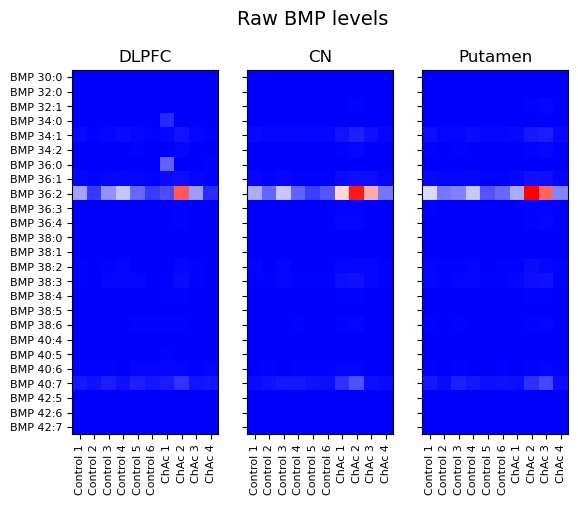

In [10]:
fig, ax = heatmap('BMP', is_standardized=False, y=1)
attila_utils.savefig(fig, 'raw-BMP-levels')

['named-figure/norm-BMP-levels.png', 'named-figure/norm-BMP-levels.pdf']

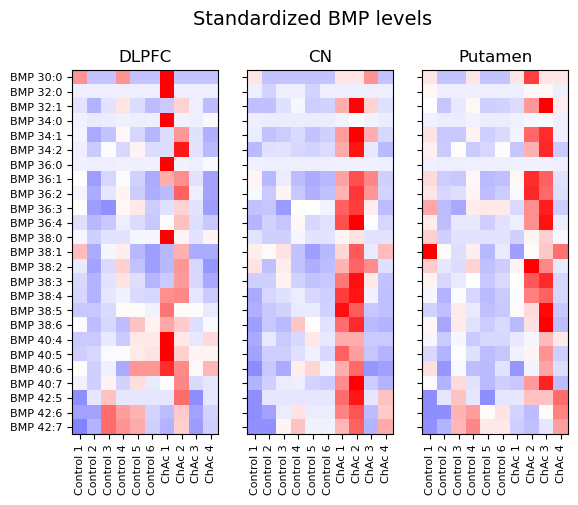

In [11]:
fig, ax = heatmap('BMP', is_standardized=True, y=1)
attila_utils.savefig(fig, 'norm-BMP-levels')

### Lipid group: Sulf

['named-figure/raw-Sulf-levels.png', 'named-figure/raw-Sulf-levels.pdf']

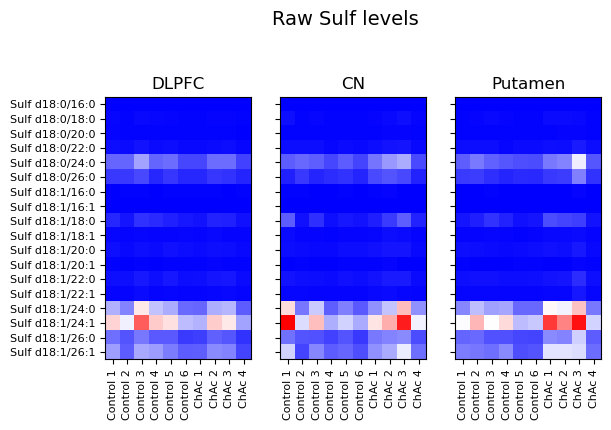

In [12]:
fig, ax = heatmap('Sulf', is_standardized=False, y=0.95)
attila_utils.savefig(fig, 'raw-Sulf-levels')

['named-figure/norm-Sulf-levels.png', 'named-figure/norm-Sulf-levels.pdf']

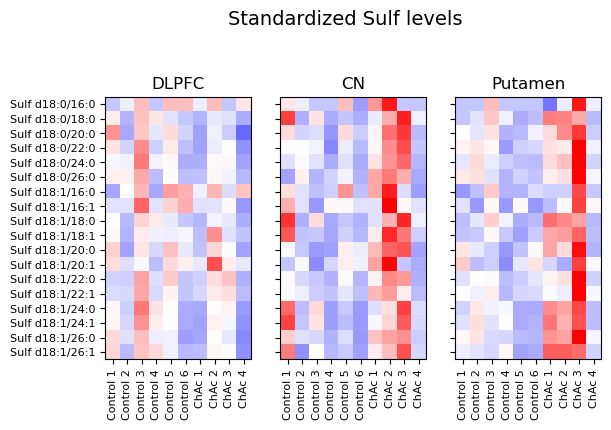

In [13]:
fig, ax = heatmap('Sulf', is_standardized=True, y=0.95)
attila_utils.savefig(fig, 'norm-Sulf-levels')

### Lipid group: PCe

['named-figure/raw-PCe-levels.png', 'named-figure/raw-PCe-levels.pdf']

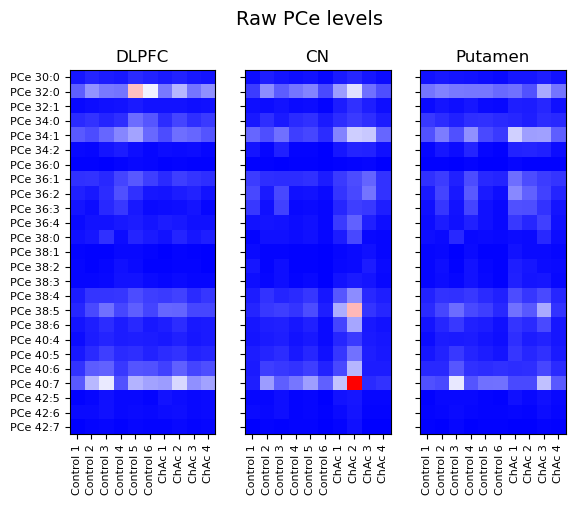

In [14]:
fig, ax = heatmap('PCe', is_standardized=False, y=1)
attila_utils.savefig(fig, 'raw-PCe-levels')

['named-figure/norm-PCe-levels.png', 'named-figure/norm-PCe-levels.pdf']

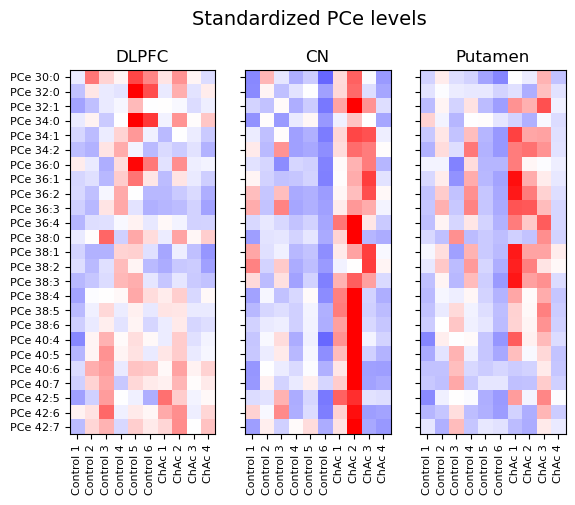

In [15]:
fig, ax = heatmap('PCe', is_standardized=True, y=1)
attila_utils.savefig(fig, 'norm-PCe-levels')

### Lipid group: LPS

['named-figure/raw-LPS-levels.png', 'named-figure/raw-LPS-levels.pdf']

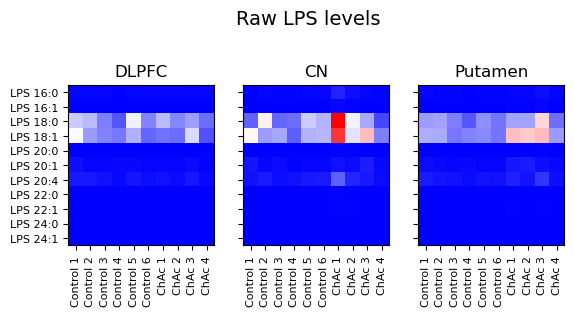

In [16]:
fig, ax = heatmap('LPS', is_standardized=False, y=0.82)
attila_utils.savefig(fig, 'raw-LPS-levels')

['named-figure/norm-LPS-levels.png', 'named-figure/norm-LPS-levels.pdf']

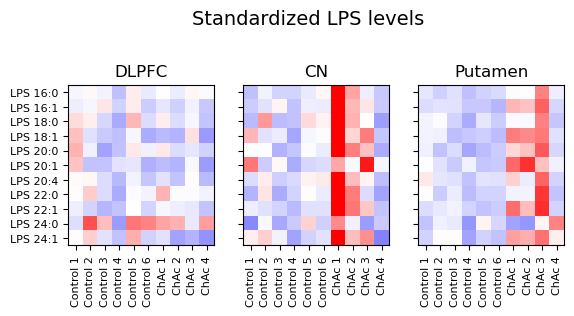

In [17]:
fig, ax = heatmap('LPS', is_standardized=True, y=0.82)
attila_utils.savefig(fig, 'norm-LPS-levels')

## Visualizing changes

['named-figure/line-ensemble.png', 'named-figure/line-ensemble.pdf']

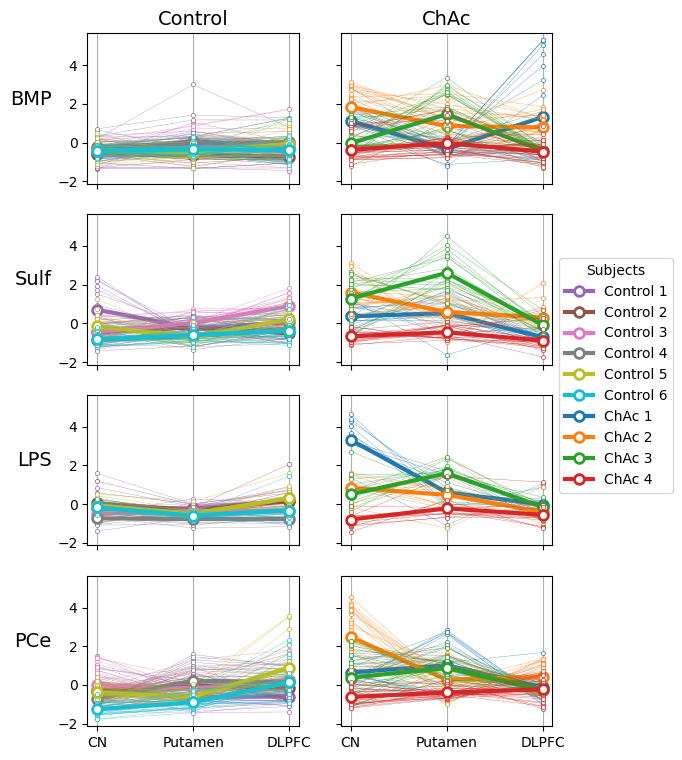

In [18]:
sel_css4_names = ['mediumpurple', 'indigo', 'violet', 'purple', 'greenyellow', 'aquamarine', 'lightgreen', 'limegreen', 'springgreen', 'turquoise']
sel_css4 = {k: mcolors.CSS4_COLORS[k] for k in sel_css4_names}

def line_ensemble(ax, group='BMP', Dx='ChAc', norm_lipid_species=std_lipid_species, setlabel=False, colordict=mcolors.TABLEAU_COLORS, plot_species=True, superposed=False):
    lgroup_levels = norm_lipid_species.xs(group, level=0, axis=0)
    nsubj = 4 if Dx == 'ChAc' else 6
    subject_names = [Dx + ' ' + str(i + 1) for i in range(nsubj)]
    offset = 0 if Dx == 'ChAc' else 4
    colors = list(colordict.values())[offset + 0: nsubj + offset]
    for subj, col in zip(subject_names, colors):
        d = lgroup_levels.xs(subj, level=0, axis=1)
        for spec in d.index:
            if plot_species:
                ax.plot(d.loc[spec], color=col, marker='o', markerfacecolor='white', markersize=3, markeredgewidth=0.5, linewidth=0.2)
        ax.plot(d.mean(), color=col, linewidth=3, marker='o', markerfacecolor='white', markersize=7, markeredgewidth=2, label=subj if setlabel else None)
        ax.grid(axis='x')
    if Dx == 'Control' and not superposed:
        ax.set_ylabel(group, y=0.5, rotation=0, horizontalalignment='right', fontsize=14)
    if superposed:
        ax.set_title(group, fontsize=14)
        #ax.set_ylabel('norm. lipid level')
    ax.grid(axis='x')
    return(ax)

def line_ensemble_main(colordict, plot_species, sel_groups=['BMP', 'Sulf', 'LPS', 'PCe']):
    fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(6, 9))
    for i, group in enumerate(sel_groups):
        setlabel = True if i == 0 else None
        line_ensemble(ax[i, 0], group, 'Control', setlabel=setlabel, colordict=colordict, plot_species=plot_species)
        line_ensemble(ax[i, 1], group, 'ChAc', setlabel=setlabel, colordict=colordict, plot_species=plot_species)
    ax[0, 0].set_title('Control', fontsize=14)
    ax[0, 1].set_title('ChAc', fontsize=14)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Subjects')
    return((fig, ax))

fig, ax = line_ensemble_main(mcolors.TABLEAU_COLORS, plot_species=True)
attila_utils.savefig(fig, 'line-ensemble')

['named-figure/line-ensemble-green-purple.png',
 'named-figure/line-ensemble-green-purple.pdf']

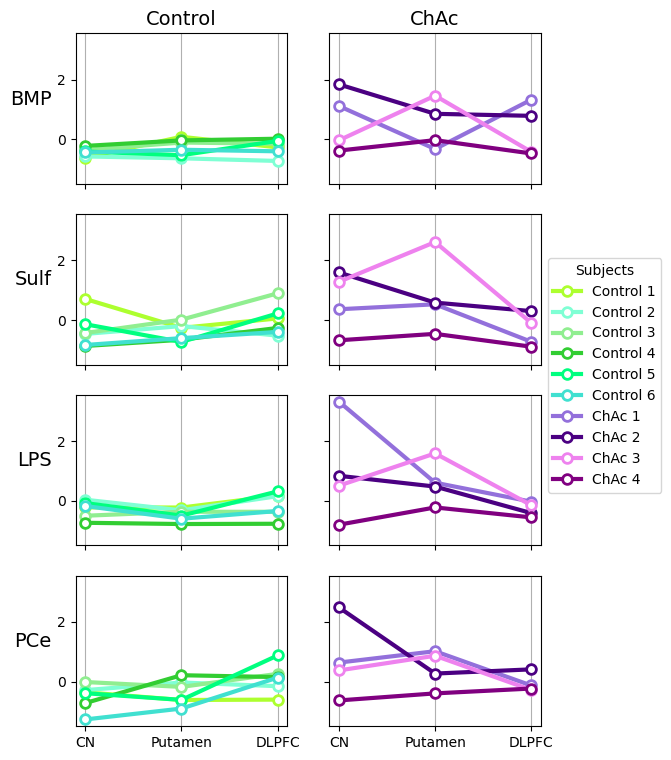

In [19]:
fig, ax = line_ensemble_main(sel_css4, plot_species=False)
attila_utils.savefig(fig, 'line-ensemble-green-purple')

<AxesSubplot:>

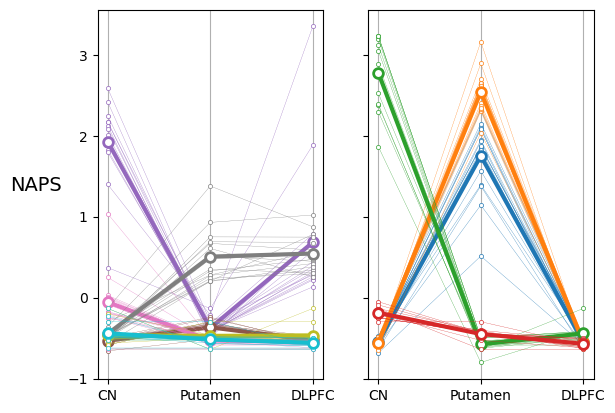

In [20]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'NAPS', 'Control')
line_ensemble(ax[1], 'NAPS', 'ChAc')

<AxesSubplot:>

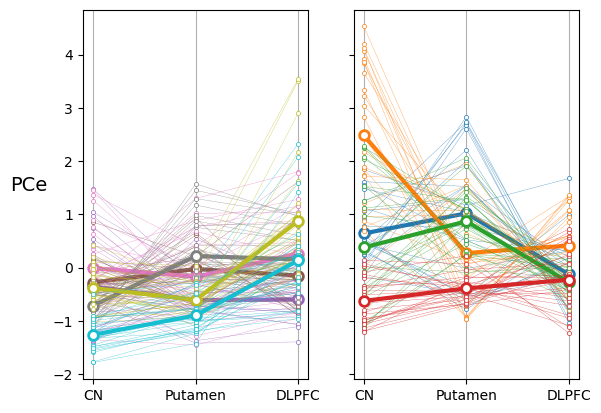

In [21]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'PCe', 'Control')
line_ensemble(ax[1], 'PCe', 'ChAc')

<AxesSubplot:>

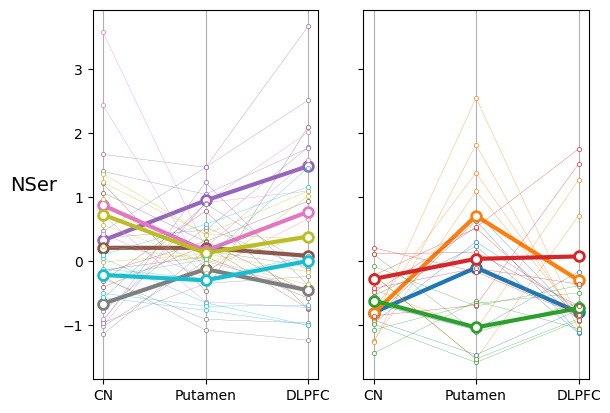

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
line_ensemble(ax[0], 'NSer', 'Control')
line_ensemble(ax[1], 'NSer', 'ChAc')

['named-figure/line-ensemble2.png', 'named-figure/line-ensemble2.pdf']

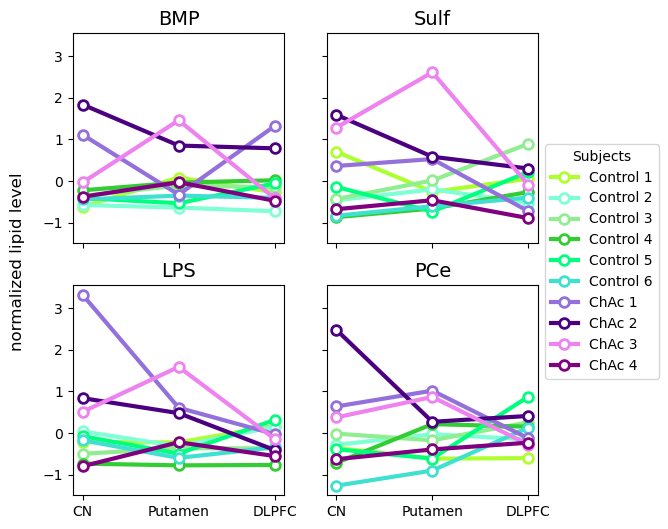

In [23]:
def line_ensemble_main2(colordict, plot_species, sel_groups=['BMP', 'Sulf', 'LPS', 'PCe']):
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
    for i, group in zip(zip(*np.unravel_index(range(len(sel_groups)), (2, 2))), sel_groups):
        setlabel = True if i == (0, 0) else None
        line_ensemble(ax[i], group, 'Control', setlabel=setlabel, colordict=colordict, plot_species=plot_species, superposed=True)
        line_ensemble(ax[i], group, 'ChAc', setlabel=setlabel, colordict=colordict, plot_species=plot_species, superposed=True)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Subjects')
    fig.supylabel('normalized lipid level')
    return((fig, ax))

fig, ax = line_ensemble_main2(sel_css4, plot_species=False, sel_groups=['BMP', 'Sulf', 'LPS', 'PCe'])
attila_utils.savefig(fig, 'line-ensemble2')

## Statistical inference

### Data overview

Our lipidomic assay quantified the level of 593 lipid species in three brain regions (DLPFC, CN and Putamen) from each of $n=10$ subjects (6 control and 4 ChAc).  Besides ChAc status (Dx variable), we knew the age at each subject's death (AgeAtDeath variable).

The 593 lipid species were classified into 34 lipid groups based on chemical structure.  The smallest group (FC, free cholesterol group) had only one species; for the rest of the groups, the number $n_g$ of lipid species ranged from 6 (NSer, N-acyl serine group) to 42 (TG, tryacylglycerol group).

Thus we had only $3 \times n = 30$ observations on each lipid species but $3 \times n \times n_g$ observations on some lipid group $g$.  Preliminary analyses showed that standardized lipid level was similarly distributed across all $n_g$ species within some lipid group $g$, which lead us to exploit the enhanced statistical power afforded by $n_g \times$ more observations and seek associations between lipid groups and ChAc rather than those between individual lipid species and ChAc.

### Data standardization

Lipid species even within the same lipid group showed highly varying overall levels.  We standardized lipid levels for both visualization (heatmap) and statistical inference (focussing on lipid groups rather than individual species to increase the number of observations).  For each lipid species $c$ we standardized lipid levels $z_{ci}$ across the $i = 1...30$ samples to obtain the standardized levels $\{y_{ci}\;:\; i = 1...30\}$:
$$
\begin{equation}
y_{ci} = (z_{ci} - \bar{z}_c) / s_c,
\end{equation}
$$

where $\bar{z}_c = 30^{-1} \sum_{i=1}^{30} z_{ci}$ is the average level of species $c$ and $s^2_c = (30 - 1)^{-1} \sum_{i=1}^{30} (z_{ci} - \bar{z}_c)^2$ is the corresponding sample variance.  After standardization the unit of lipid level change is the sample standard deviation $s_c$.

### Statistical assumptions

Let us focus on lipid group $g$ with $n_g$ lipid species in it.  As before $n=10$ is the number of subjects so that the number of samples is $3n = 30$ due to sampling each subject from three brain regions.  We assume that 
1. The level of some lipid species $c \in g$ is conditionally i.i.d across all samples
1. The standardized level of species $c$ is conditionally i.i.d across all $c \in g$,

where conditionally i.i.d means independent and identically distributed lipid across all samples for a given ChAc status, brain region and age at death.  Standardization is essential for the second assumption because lipid level typically varies greatly across all species $c \in g$.

Under these two assumptions that we may treat lipid levels across all $3n$ samples and all $n_g$ lipid species $c \in g$ as conditionally i.i.d random variables.  Therefore we can arrange all lipid levels into an $m = 3 \times n \times n_g$ long vector $\mathbf{y}_g$ corresponding to $m$ observations on the level of lipid group $g$.  If we analyzed all lipid species $c \in g$ separately from each other, we would have only $3 \times n$ observations for each lipid species, $n_g \times$ fewer observations and so we would have to deal with $\approx \sqrt n_g \times$ larger errors than in the present case.  (The last statement follows from the central limit theorem.)  Note that the $\approx \sqrt n_g \times$ reduction of error is the most beneficial for large lipid groups.  For instance, the PC (phosphatidylcholine) group contains $n_g = 25$ species, which means $\approx 5 \times$ reduction in error.

### Regression model

For each lipid group $g$ we modeled standardized lipid level using linear regression with the symbolic formula `Level ~ 1 + Region + Dx:Region + AgeAtDeath`.  This means that we regressed standardized lipid level (Level) on a linear combination of fixed effects terms: brain region (Region), the combination of region and ChAc status (Dx:Region, the interaction term of our main interest), and on the age at death (AgeAtDeath).  In addition, we added a random effects term that modeled subject-to-subject heterogeneity of lipid levels.  Therefore our model could be written as
$$
\begin{equation}
\mathbf{y}_{g} = \sum_{j=0}^{p} \beta_{gj} \mathbf{x}_{gj} + \mathbf{\gamma}_{g} + \mathbf{\epsilon}_{g},
\end{equation}
$$
where $\mathbf{y}_{g}$ is the $m$-length data vector of standardized lipid level from $m = 3 n n_g$ observations; $\{\mathbf{x}_{gj}\}_j$ are $m$-length data vectors as defined in the table and equations below; $\mathbf{\gamma}_{g}$ and $\mathbf{\epsilon}_{g}$ are both random $m$-vectors such that
$\mathbf{\gamma}_{g} \sim \mathcal{N}(\mathbf{0}_m, \sigma^2_{\gamma g}\Omega_g)$ and
$\mathbf{\epsilon}_{g} \sim \mathcal{N}(\mathbf{0}_m, \sigma^2_{\epsilon g} \mathbf{I}_m)$, respectively.  Here $\Omega$ is the $m \times m$ correlation matrix of $\mathbf{\gamma}_{g}$ constrained such that all observations from the same subject change by the same random amount (they have a correlation of one between each other), while observations from different subjects are independent from each other (they have zero correlation).

| symbol | length $m$ | symbol in model | description |
|---|---|---|---|
| $\mathbf{y}_{g}$ | $3 n n_g$ | $\mathbf{y}_{g}$ | lipid level in lipid group $g$ |
| $\mathbf{x}_{g\mathrm{CN}}$ | $3 n n_g$ | $x_{g1}$ | 1 for samples from CN, 0 otherwise |
| $\mathbf{x}_{g\mathrm{Putamen}}$ | $3 n n_g$ | $x_{g2}$ | 1 for samples from Putamen, 0 otherwise |
| $\mathbf{x}_{g\mathrm{DLPFC}}$ | $3 n n_g$ | | 1 for samples from DLPFC, 0 otherwise |
| $\mathbf{x}_{g\mathrm{ChAc}}$ | $3 n n_g$ |  | 1 for samples from ChAc subjects, 0 otherwise |
| $\mathbf{x}_{g\mathrm{AgeAtDeath}}$ | $3 n n_g$ | $x_{g6}$ | age at death in years |

$$
\begin{eqnarray}
\mathbf{x}_{g3} &=& \mathbf{x}_{g\mathrm{DLPFC}} \circ \mathbf{x}_{g\mathrm{ChAc}} \\
\mathbf{x}_{g4} &=& \mathbf{x}_{g\mathrm{CN}} \circ \mathbf{x}_{g\mathrm{ChAc}} \\
\mathbf{x}_{g5} &=& \mathbf{x}_{g\mathrm{Putamen}} \circ \mathbf{x}_{g\mathrm{ChAc}} \\
\end{eqnarray}
$$

The regression parameters $\{\beta_{gj}\}_j$ and their interpretations are listed in the table below.  The parameters of our main interest are $\beta_{3g}, \beta_{4g}, \beta_{5g}$ corresponding to the terms $\{$Dx[T.ChAc]:Region[$r$]$ \; : \; r \in \{\mathrm{DLPFC}, \mathrm{CN}, \mathrm{Putamen}\}\}$, respectively.

| Parameter | Term | Interpretation of parameter's effect | Interpretation of term |
|--|--|--|--|
| $\beta_{0g}$ | Intercept | reference level | avg. standardized lipid level in DLPFC across all control subjects and all lipid species within lipid group |
| $\beta_{1g}$ | Region[T.CN] | fixed effect of the CN region w.r.t DLPFC | avg. standardized lipid level in CN w.r.t DLPFC across all control subjects and lipid species within lipid group |
| $\beta_{2g}$ | Region[T.Putamen] | fixed effect of the Putamen region w.r.t DLPFC |fixed effect of brain region | avg. standardized lipid level in Putamen w.r.t DLPFC across all control subjects and all lipid species within lipid group |
| $\beta_{3g}$ | Dx[T.ChAc]:Region[DLPFC] | fixed, DLPFC-specific, effect of ChAc status | avg. standardized lipid level in ChAc w.r.t Control, in DLPFC, across all ChAc subjects and all lipid species within lipid group |
| $\beta_{4g}$ | Dx[T.ChAc]:Region[CN] | fixed, CN-specific, effect of ChAc status | avg. standardized lipid level in ChAc w.r.t Control, in CN, across all ChAc subjects and all lipid species within lipid group |
| $\beta_{5g}$ | Dx[T.ChAc]:Region[Putamen] | fixed, Putamen-specific, effect of ChAc status | avg. standardized lipid level in ChAc w.r.t Control, in Putamen, across all ChAc subjects and all lipid species within lipid group |
| $\beta_{6g}$ |  AgeAtDeath | fixed effect of age | change in avg. standardized lipid level per year across all brain regions and all lipid species within lipid group |
| $\sigma_{\gamma g}$ | Subject Var | random effect of cross-subject variation | cross-subject standard deviation of avg. standardized lipid level across all lipid species within lipid group  |

### Fitting models

`Level ~ 1 + Region + Dx:Region + AgeAtDeath`

In [24]:
def extract_group(group, df=data):
    val = df.xs(group, axis=0, level='Group')
    return(val)

def fit_to_group(formula, group, effects='mixed', df=stddata):
    d = extract_group(group, df)
    if effects == 'mixed':
        md = smf.mixedlm(formula, data=d, groups='Subject')
        # Random effect of the Region:Subject was tested but is not used here
        #  as it decreases the power of testing the Dx:Region fixed effect.
        #md = smf.mixedlm(formula, data=d, groups='Region:Subject') 
    if effects == 'fixed':
        md = smf.ols(formula, data=d)
    mdf = md.fit()
    return(mdf)

### Models of increasing complexity

More complex models fit the same data in general at least as well, if not better, as (nested) less complex models.  Too complex models, however, tend to overfit the data and the parameter estimates become unstable.

In [25]:
formulas = ['Level ~ 1', 'Level ~ 1 + Dx', 'Level ~ 1 + Region', 'Level ~ 1 + Dx:Region', 'Level ~ 1 + Dx:Region + AgeAtDeath', 'Level ~ 1 + Dx:Region + AgeAtDeath + PMI', 'Level ~ 1 + Dx + Dx:Region', 'Level ~ 1 + Dx + Region + Dx:Region']
#sel_groups = ['BMP', 'Sulf', 'PG']

In [26]:
def fit_all_models_to_group(group, formulas, stddata=stddata, do_mixed=False):
    effects = ['fixed', 'mixed'] if do_mixed else ['fixed']
    l = [[fit_to_group(f, group, fx, df=stddata) for f in formulas] for fx in effects]
    ix = pd.MultiIndex.from_product([effects, formulas])
    res = pd.DataFrame({group: itertools.chain(*l)}, index=ix)
    return(res)

fitted_models = pd.concat([fit_all_models_to_group(group, formulas, do_mixed=True) for group in lipid_groups.index], axis=1)

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [27]:
fitted_groupmodels = pd.concat([fit_all_models_to_group(group, formulas, stddata=stdgroupdata, do_mixed=True) for group in lipid_groups.index], axis=1)

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: Conv

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the param

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: Conv

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:

## Inference using various models

I inspect models here whose formula is:

> Level ~ 1 + Dx:Region + AgeAtDeath

Summary on these parameters for the PC group:

In [28]:
m = fitted_models.loc[('mixed', 'Level ~ 1 + Dx:Region + AgeAtDeath + PMI'), 'PC']
m.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                  MixedLM     Dependent Variable:     Level    
No. Observations:       750         Method:                 REML     
No. Groups:             10          Scale:                  0.6117   
Min. group size:        75          Log-Likelihood:         -906.8063
Max. group size:        75          Converged:              Yes      
Mean group size:        75.0                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.012    2.287  0.005 0.996 -4.470  4.495
Region[T.CN]               -0.899    0.090 -9.955 0.000 -1.076 -0.722
Region[T.Putamen]          -0.689    0.090 -7.634 0.000 -0.866 -0.512
Dx[T.ChAc]:Region[DLPFC]    0.036    0.509  0.071 0.944 -0.961  1.033
Dx[T.ChAc]:Region[CN]       0.746    0.509  1.467 0.142 -0.251  1.744
Dx[T.ChAc]:Region[Putamen]  0.115    0.509  0.226 0.821 -0.882  1.112
AgeAtDeath                  0.005    0.037  0.145 0.885 -0.068  0.079
PMI                         0.005    0.029  0.162 0.871 -0.052  0.061
Subject Var                 0.386    0.292                           
=====================================================================

"""

### Goals

The goals of this section: compare inferred effects and their significance across...
1. group-level and species-level data
1. the presence and absence of random sample effects

### Differential effect of ChAc across regions

Of perhaps the most important biomedical interest is the differential effect of ChAc across regions.  The conclusions from the following analyses are:
1. inference from species-level data is qualitatively consistent with that from group-level data
1. quantitatively viewing it, inference from species-level data yields smaller estimated false negative errors (i.e yields lower $p$-values)
1. the mixed effects flavor gives somewhat greater estimated false negative errors than the fixed effects one

In [29]:
fittedm = {'group-level data': fitted_groupmodels, 'species-level data': fitted_models}

formula = 'Level ~ 1 + Dx:Region + AgeAtDeath'
formula_pmi = 'Level ~ 1 + Dx:Region + AgeAtDeath + PMI'

def extract_property(fun, formula=formula, fittedm=fittedm):
    def helper(dataset='group-level data'):
        df = fittedm[dataset].xs(formula, level=1, axis=0)
        effects = np.unique(df.index.get_level_values(0))
        res = pd.concat([df.loc[fx].apply(fun) for fx in effects], axis=1)
        res.columns = pd.MultiIndex.from_product([[dataset], effects])
        return(res)
    l = [helper(ds) for ds in fittedm.keys()]
    res = pd.concat(l, axis=1)
    return(res)

fun = lambda m: m.tvalues.loc['Dx[T.ChAc]:Region[CN]']
tvalues = extract_property(fun)

def concat_results(df, df_pmi, formula=formula, formula_pmi=formula_pmi):
    df_all = pd.concat([df, df_pmi], axis=1)
    columns = pd.concat([pd.DataFrame({'formula': [formula] * 4 + [formula_pmi] * 4}, index=df_all.columns), df_all.columns.to_frame()], axis=1)
    columns.columns = [columns.columns[0]] + ['dataset', 'effects']
    df_all.columns = pd.MultiIndex.from_frame(columns)
    return(df_all)

tvalues_CN_all = concat_results(*[extract_property(fun, formula=f) for f in [formula, formula_pmi]])
tvalues_CN_all

formula Level ~ 1 + Dx:Region + AgeAtDeath                               \
dataset                   group-level data           species-level data   
effects                              fixed     mixed              fixed   
FC                               -0.134748 -0.134192          -0.134748   
CE                                0.436037  0.432056           0.897179   
AC                                0.097579  0.089774          -0.535469   
MG                                2.290030  2.290021           5.277972   
DG                               -0.521607 -0.505810           0.709792   
TG                                2.053008  2.012967          12.337777   
Cer                               0.456874  0.441542           1.255454   
dhCer                            -0.241270 -0.233854          -0.741274   
SM                                0.857843  0.850146           4.881332   
dhSM                              0.474414  0.472054           2.009628   
MhCer                             1.339359  1.290190           5.978262   
Sulf                              2.504913  2.391916          10.113460   
LacCer                           -1.261321 -1.202224          -6.453511   
GM3                              -0.290927 -0.287427           2.519385   
GB3                               0.445367  0.441233          -1.289641   
PA                               -1.622486 -1.533604          -8.075642   
PC                                1.054207  1.034741           5.777742   
PCe                               3.004222  2.938213          11.286554   
PE                               -0.118695 -0.118637          -0.171404   
PEp                               0.516602  0.514504           2.819891   
PS                                1.264129  1.251219           7.382807   
PI                               -0.525593 -0.514511          -2.003610   
PG                               -1.922800 -1.865321          -8.799280   
BMP                               3.390200  3.139564          10.325066   
AcylPG                            0.028348  0.026242           0.535955   
LPC                              -0.006083 -0.006028          -0.744375   
LPCe                              0.185249  0.183986           2.061661   
LPE                               0.249226  0.244611           3.237400   
LPEp                              1.403435  1.334052           2.870184   
LPI                              -1.448077 -1.428395          -2.677287   
LPS                               2.570652  2.468954           8.199903   
NAPE                              0.180139  0.167750           1.205200   
NAPS                              1.034612  1.034594           3.687822   
NSer                             -1.776011 -1.730439          -4.267262   

formula           Level ~ 1 + Dx:Region + AgeAtDeath + PMI            \
dataset                                   group-level data             
effects     mixed                                    fixed     mixed   
FC      -0.134192                                -0.515004 -0.515004   
CE       0.318698                                -0.192470 -0.192470   
AC      -0.212197                                -0.139679 -0.115194   
MG       2.835073                                 2.156974  2.156959   
DG       0.256557                                -0.752867 -0.696296   
TG       2.555910                                 2.545980  2.466765   
Cer      0.683411                                 0.483119  0.441134   
dhCer   -0.377108                                -0.132527 -0.121845   
SM       2.146794                                 0.726348  0.702415   
dhSM     1.088776                                 0.988596  0.988551   
MhCer    1.668917                                 1.318486  1.195437   
Sulf     3.565310                                 2.210000  1.967456   
LacCer  -1.477214                                -0.825249 -0.737704   
GM3      1.575419                                -0.550938 -0.550938   


['named-figure/t-value-heatmap-fixed-mixed-models.png',
 'named-figure/t-value-heatmap-fixed-mixed-models.pdf']

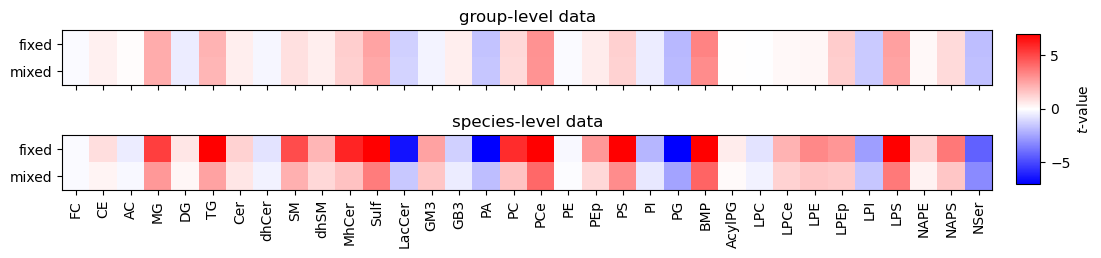

In [30]:
def imshow_extracted(extracted, cb_label, cmap='bwr', autoscale=True, vmin=-1, vmax=1):
    fig, ax = plt.subplots(2, 1, figsize=(12, 2.5), sharex=True)
    datasets = extracted.xs('fixed', level=1, axis=1).columns
    vmin = extracted.min(axis=0).min() if autoscale else vmin
    vmax = extracted.max(axis=0).max() if autoscale else vmax
    for axi, dset in zip(ax, datasets):
        df = extracted.xs(dset, level=0, axis=1)
        axi.imshow(df.transpose(), cmap=cmap, vmin=vmin, vmax=vmax)
        axi.set_title(dset)
        axi.set_yticks(range(df.shape[1]))
        axi.set_yticklabels(df.columns)
        axi.set_xticks(range(df.shape[0]))
        axi.set_xticklabels(df.index, rotation=90)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    #fig.suptitle(suptitle, fontsize=14)
    return((fig, ax))

fig, ax = imshow_extracted(tvalues, r'$t$-value', autoscale=False, vmin=-7, vmax=7)
attila_utils.savefig(fig, 't-value-heatmap-fixed-mixed-models')

In [31]:
fun = lambda m: m.pvalues.loc['Dx[T.ChAc]:Region[CN]']
pvalues_CN_all = concat_results(*[extract_property(fun, formula=f) for f in [formula, formula_pmi]])
pvalues_CN_all

formula Level ~ 1 + Dx:Region + AgeAtDeath                               \
dataset                   group-level data           species-level data   
effects                              fixed     mixed              fixed   
FC                                0.893983  0.893251       8.939832e-01   
CE                                0.666875  0.665701       3.699876e-01   
AC                                0.923112  0.928467       5.927778e-01   
MG                                0.031522  0.022020       1.904117e-07   
DG                                0.606931  0.612990       4.780317e-01   
TG                                0.051617  0.044118       4.336049e-33   
Cer                               0.652047  0.658820       2.101443e-01   
dhCer                             0.811484  0.815098       4.590201e-01   
SM                                0.399831  0.395244       1.598899e-06   
dhSM                              0.639678  0.636888       4.523119e-02   
MhCer                             0.193540  0.196985       3.564058e-09   
Sulf                              0.019779  0.016761       4.102294e-22   
LacCer                            0.219837  0.229277       2.018584e-10   
GM3                               0.773714  0.773785       1.204730e-02   
GB3                               0.660218  0.659044       1.980196e-01   
PA                                0.118328  0.125127       2.706324e-15   
PC                                0.302737  0.300790       1.113529e-08   
PCe                               0.006327  0.003301       2.236534e-27   
PE                                0.906548  0.905563       8.639528e-01   
PEp                               0.610366  0.606899       4.937390e-03   
PS                                0.218845  0.210855       4.332580e-13   
PI                                0.604202  0.606895       4.548976e-02   
PG                                0.066974  0.062136       9.547449e-18   
BMP                               0.002518  0.001692       1.909291e-23   
AcylPG                            0.977630  0.979065       5.922590e-01   
LPC                               0.995199  0.995190       4.573144e-01   
LPCe                              0.854658  0.854024       4.022268e-02   
LPE                               0.805398  0.806758       1.361035e-03   
LPEp                              0.173845  0.182187       4.479683e-03   
LPI                               0.161091  0.153178       7.888891e-03   
LPS                               0.017095  0.013551       5.742077e-15   
NAPE                              0.858621  0.866780       2.288702e-01   
NAPS                              0.311607  0.300858       2.524238e-04   
NSer                              0.088964  0.083552       3.252951e-05   

formula           Level ~ 1 + Dx:Region + AgeAtDeath + PMI            \
dataset                                   group-level data             
effects     mixed                                    fixed     mixed   
FC       0.893251                                 0.611686  0.606550   
CE       0.749955                                 0.849140  0.847374   
AC       0.831953                                 0.890185  0.908292   
MG       0.004582                                 0.042198  0.031009   
DG       0.797521                                 0.459511  0.486243   
TG       0.010591                                 0.018415  0.013634   
Cer      0.494347                                 0.633784  0.659116   
dhCer    0.706093                                 0.895772  0.903022   
SM       0.031810                                 0.475283  0.482420   
dhSM     0.276253                                 0.333610  0.322883   
MhCer    0.095134                                 0.200903  0.231916   
Sulf     0.000363                                 0.037813  0.049131   
LacCer   0.139618                                 0.418089  0.460694   
GM3      0.115160                                 0.587228  0.581676   


['named-figure/p-value-heatmap-fixed-mixed-models.png',
 'named-figure/p-value-heatmap-fixed-mixed-models.pdf']

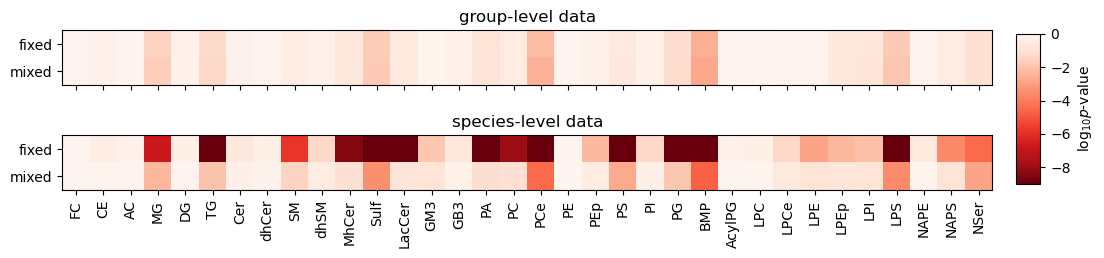

In [32]:
fun = lambda m: np.log10(m.pvalues.loc['Dx[T.ChAc]:Region[CN]'])
pvalues_CN = extract_property(fun)

fig, ax = imshow_extracted(pvalues_CN, r'$\log_{10}p$-value', cmap='Reds_r', autoscale=False, vmin=-9, vmax=0)
attila_utils.savefig(fig, 'p-value-heatmap-fixed-mixed-models')

### Effect of PMI as a covariate

['named-figure/PMI-effect-on-estimate-pval.png',
 'named-figure/PMI-effect-on-estimate-pval.pdf']

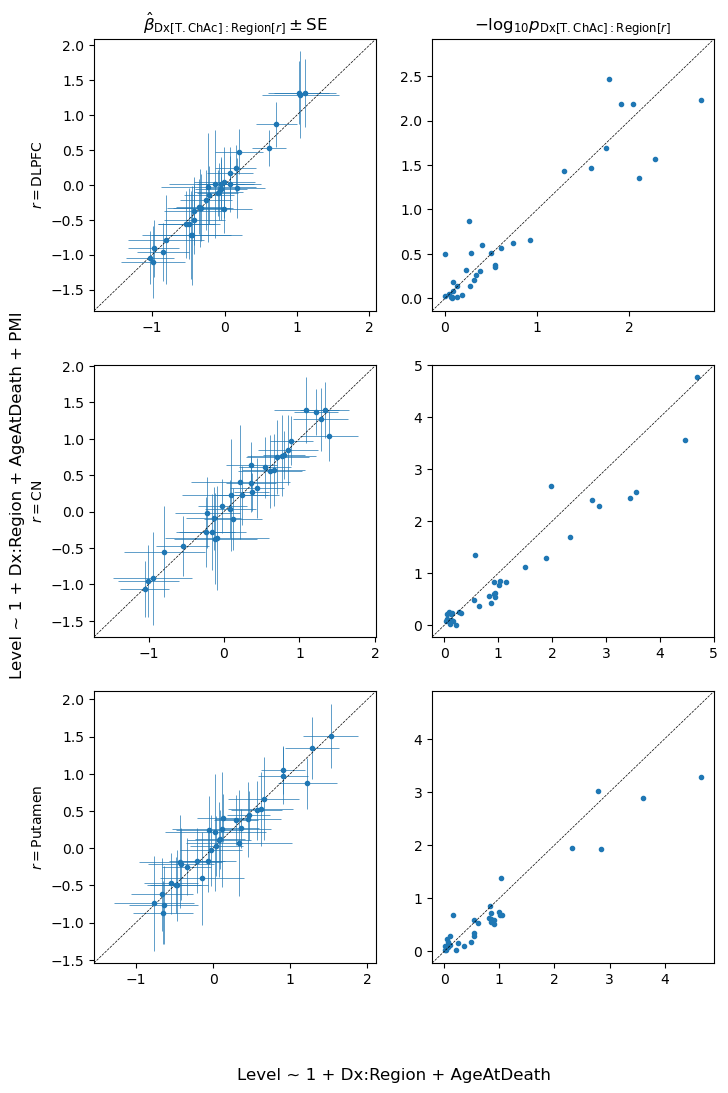

In [33]:
regions = ['DLPFC', 'CN', 'Putamen']
def collect_all_results(attribute='tvalues', regions=regions):
    d = {region: concat_results(*[extract_property(lambda m: getattr(m, attribute).loc['Dx[T.ChAc]:Region[' + region + ']'], formula=f) for f in [formula, formula_pmi]]) for region in regions}
    return(d)

tvalues_all = collect_all_results(attribute='tvalues')
pvalues_all = collect_all_results(attribute='pvalues')
neglog_pvalues_all = {k: v.applymap(lambda p: -np.log10(p)) for k, v in pvalues_all.items()}
params_all = collect_all_results(attribute='params')
SE_all = collect_all_results(attribute='bse')

def pmi_effect_scatter(df, ax, df_SE=None, dataset='species-level data', effects='mixed', formula=formula, formula_pmi=formula_pmi):
    if df_SE is None:
        ax.scatter(*[df[(f, dataset, effects)] for f in [formula, formula_pmi]], marker='.')
    else:
        x = df[(formula, dataset, effects)]
        y = df[(formula_pmi, dataset, effects)]
        xerr = df_SE[(formula, dataset, effects)]
        yerr = df_SE[(formula_pmi, dataset, effects)]
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='C0.', linewidth=0.5, capsize=0)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.axline(xy1=(0,0), xy2=None, slope=1, color='k', linestyle='dashed', linewidth=0.5)
    return(ax)


fig, ax = plt.subplots(len(regions), 2, figsize=(8, len(regions) * 4))
for i, region in zip(range(len(regions)), regions):
    if i == 0:
        subscript = '_{\mathrm{Dx[T.ChAc]}:\mathrm{Region[}r\mathrm{]}}'
        ax[i, 0].set_title(r'$\hat{\beta}' + subscript + ' \pm \mathrm{SE}$')
        ax[i, 1].set_title(r'$- \log_{10} p' + subscript + '$')
    ax[i, 0].set_ylabel(r'$r = $' + region)#, rotation=0, horizontalalignment='right')
    ax[i, 0] = pmi_effect_scatter(params_all[region], ax[i, 0], df_SE=SE_all[region])
    ax[i, 1] = pmi_effect_scatter(neglog_pvalues_all[region], ax[i, 1])
    #ax[i, 1].set_xscale('log')
    #ax[i, 1].set_yscale('log')
fig.supxlabel(formula)
fig.supylabel(formula_pmi)
attila_utils.savefig(fig, 'PMI-effect-on-estimate-pval')

In [34]:
pvalues_PMI = extract_property(lambda m: getattr(m, 'pvalues').loc['PMI'], formula=formula_pmi)
pvalues_PMI

group-level data           species-level data          
                  fixed     mixed              fixed     mixed
FC             0.226197  0.213097       2.261970e-01  0.213097
CE             0.052253  0.040165       5.302206e-07  0.255446
AC             0.462241  0.671815       2.297672e-04  0.369116
MG             0.931574  0.930790       6.847565e-01  0.892216
DG             0.409811  0.526729       1.697793e-01  0.769139
TG             0.108008  0.140801       3.053072e-26  0.155925
Cer            0.853342  0.892022       8.420852e-01  0.946419
dhCer          0.768309  0.825253       4.696793e-01  0.821626
SM             0.817105  0.838105       9.414405e-01  0.984641
dhSM           0.107107  0.093008       2.476969e-06  0.044279
MhCer          0.819737  0.869660       9.446963e-01  0.991092
Sulf           0.681534  0.778177       7.210802e-01  0.941366
LacCer         0.221733  0.389191       6.409764e-10  0.398748
GM3            0.382933  0.373299       5.528072e-02  0.414832
GB3            0.288026  0.276242       1.812410e-04  0.350494
PA             0.966520  0.978325       4.719941e-01  0.926936
PC             0.825233  0.856786       3.375977e-01  0.871101
PCe            0.475256  0.562348       7.751749e-02  0.700280
PE             0.439461  0.446244       1.231094e-02  0.579892
PEp            0.768905  0.785700       4.333520e-01  0.858137
PS             0.556052  0.600946       3.990983e-02  0.596747
PI             0.844566  0.875231       3.730783e-01  0.873683
PG             0.815507  0.860551       1.905114e-01  0.830134
BMP            0.011510  0.094544       7.550605e-05  0.292891
AcylPG         0.677375  0.806610       1.013345e-02  0.697755
LPC            0.551218  0.592795       6.498372e-02  0.601761
LPCe           0.804455  0.823499       1.022551e-01  0.534180
LPE            0.890919  0.910914       1.921406e-01  0.697398
LPEp           0.604083  0.727814       3.483676e-01  0.772522
LPI            0.971514  0.975857       2.798961e-01  0.691255
LPS            0.010304  0.020759       6.962401e-11  0.023022
NAPE           0.494826  0.678240       1.335359e-03  0.611480
NAPS           0.907299  0.906250       1.798911e-01  0.734797
NSer           0.924122  0.941241       8.762063e-01  0.935807

['named-figure/pvalues-PMI-effect.png', 'named-figure/pvalues-PMI-effect.pdf']

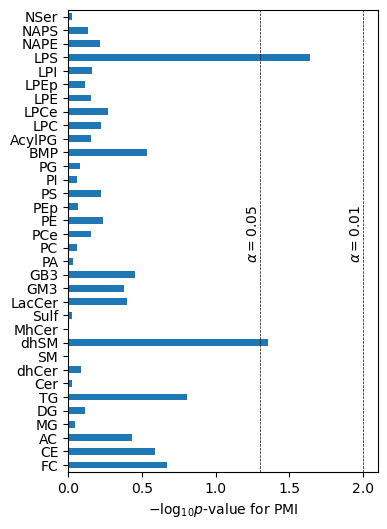

In [35]:
fig, ax = plt.subplots(figsize=(4, 6))
pvalues_PMI.xs('species-level data', level=0, axis=1)['mixed'].apply(lambda p: - np.log10(p)).plot(kind='barh', ax=ax)
ax.axvline(- np.log10(0.05), color='k', linewidth=0.5, linestyle='dashed')
ax.axvline(- np.log10(0.01), color='k', linewidth=0.5, linestyle='dashed')
for alpha in [0.05, 0.01]:
    ax.text(- np.log10(alpha), len(pvalues_PMI) / 2, r'$\alpha = ' + str(alpha) + '$', rotation=90, horizontalalignment='right', verticalalignment='center')
ax.set_xlabel(r'$-\log_{10}p$-value for PMI')
attila_utils.savefig(fig, 'pvalues-PMI-effect')

## Volcano plots

In [36]:
def get_pvalues_w_correction(formula=formula, brain_regions=brain_regions1):
    l = [extract_property(lambda m: m.pvalues.loc['Dx[T.ChAc]:Region[' + r +']'], formula=formula)[('species-level data', 'mixed')] for r in brain_regions]
    pvalues = pd.concat(l, axis=1)
    pvalues.columns = brain_regions1
    log10pvalues = pvalues.applymap(np.log10)
    pvalues_long = pvalues.unstack()
    reject_long, pvals_corrected_long, alphacSidak, alphacBonf = sm.stats.multipletests(pvalues_long, method='fdr_bh')
    reject_long = pd.Series(reject_long, index=pvalues_long.index)
    val = {
        'pvalues': pvalues,
        'log10pvalues': log10pvalues,
        'pvalues_long': pvalues_long,
        'reject_long': reject_long,
        'alphacBonf': alphacBonf,
    }
    return(val)

pvalues = get_pvalues_w_correction(formula=formula)
pvalues_pmi = get_pvalues_w_correction(formula=formula_pmi)

['named-figure/pvalues-corrected-wo-PMI.png',
 'named-figure/pvalues-corrected-wo-PMI.pdf']

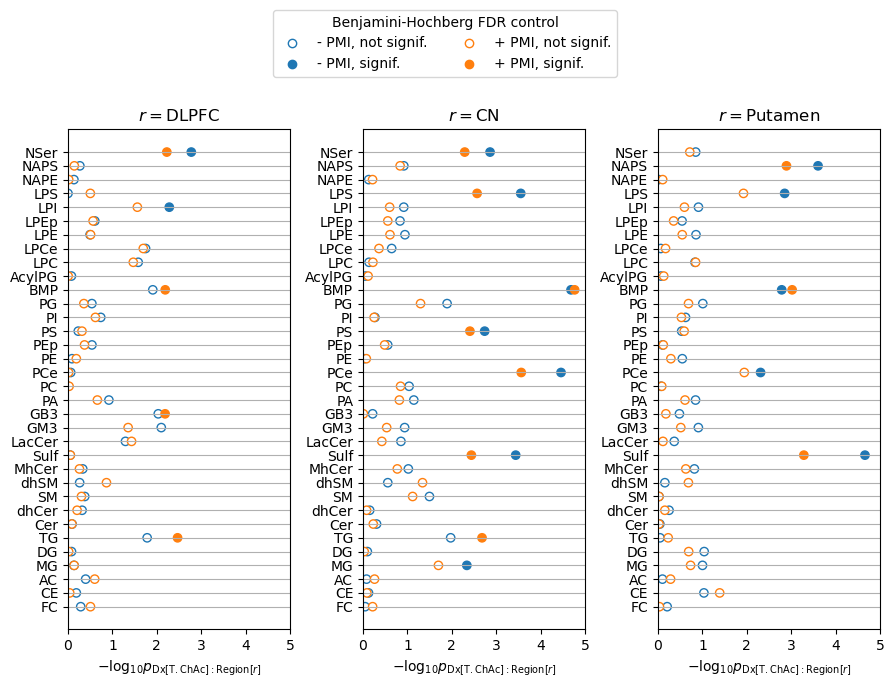

In [37]:
def line2d_legend(markeredgecolor='red', markerfacecolor='pink', label='signif. increase'):
    line = Line2D([0, 1], [0, 0], linewidth=0, markeredgecolor=markeredgecolor, markerfacecolor=markerfacecolor, label=label, marker='o')
    return(line)

fig, ax = plt.subplots(1, 3, figsize=(9, 6))
subscript = '_{\mathrm{Dx[T.ChAc]}:\mathrm{Region[}r\mathrm{]}}'
for i, region in enumerate(regions):
    axi = ax[i]
    dat = pd.concat([df['log10pvalues'][[region]].rename({region: key}, axis=1) for key, df in {'- PMI': pvalues, '+ PMI': pvalues_pmi}.items()], axis=1)
    dat = dat.applymap(lambda x: -x)
    rej = pd.concat([df['reject_long'].xs(region, level=0, axis=0).to_frame('- PMI') for key, df in {'- PMI': pvalues, '+ PMI': pvalues_pmi}.items()], axis=1)
    col = pd.concat([df['reject_long'].xs(region, level=0, axis=0).to_frame(key).applymap(lambda b: c if b else 'white') for key, df, c in zip(['- PMI', '+ PMI'], [pvalues, pvalues_pmi], ['C0', 'C1'])], axis=1)
    ys = list(range(len(dat)))
    axi.scatter(x=dat.loc[:, '- PMI'], y=ys, c=col.loc[:, '- PMI'], edgecolors='C0')
    axi.scatter(x=dat.loc[:, '+ PMI'], y=ys, c=col.loc[:, '+ PMI'], edgecolors='C1')
    axi.set_yticks(ys)
    axi.set_yticklabels(dat.index)
    axi.grid(axis='y')
    axi.set_title(r'$r = $' + region)
    axi.set_xlim(0, 5)
    axi.set_xlabel((r'$-\log_{10}p' + subscript + '$'))
fig.tight_layout()
fig.legend(handles=[line2d_legend('C0', 'white', '- PMI, not signif.'),
                    line2d_legend('C0', 'C0', '- PMI, signif.'),
                    line2d_legend('C1', 'white', '+ PMI, not signif.'),
                    line2d_legend('C1', 'C1', '+ PMI, signif.'),
                   ], title='Benjamini-Hochberg FDR control', ncol=2,
           loc='upper center', bbox_to_anchor=(0.5, 1.15))

attila_utils.savefig(fig, 'pvalues-corrected-wo-PMI')

Fold changes

In [38]:
def get_fold_change(group, region, data=data):
    df = data.xs(group, level='Group', axis=0).xs(region, level='Region', axis=0)
    Control = df.loc[df.Dx == 'Control']
    ChAc = df.loc[df.Dx == 'ChAc']
    fc = ChAc.Level.mean() / Control.Level.mean()
    return(fc)

a = np.array([[get_fold_change(g, r) for r in brain_regions1] for g in lipid_groups.index])
fold_changes = pd.DataFrame(a, index=lipid_groups.index, columns=brain_regions1)
log2fold_changes = fold_changes.applymap(np.log2)
#log2fold_changes

Color vectors for volcano plots

In [39]:
def unstack_corrected(a, index=pvalues['pvalues_long'].index):
    s = pd.Series(a, index=index)
    df = s.unstack(level=0)
    return(df)

def make_colorvec(palette=['red', 'blue', 'gray'], reject_long=pvalues['reject_long'], fold_changes=fold_changes):
    colorvec_long = [(lambda x: palette[0] if x else palette[2])(b) for b in reject_long]
    colorvec_long = [c if f >= 1 or c == palette[2] else palette[1] for c, f in zip(colorvec_long, fold_changes.unstack())]
    colorvec = unstack_corrected(colorvec_long)
    return(colorvec)

edgecolors = make_colorvec(palette=['red', 'blue', 'gray'])
facecolors = make_colorvec(palette=['pink', 'lightblue', 'lightgray'])

Text vectors for volcano plots

In [40]:
textvec = edgecolors.apply(lambda s: s.index, axis=0)
textvec_long = [t if r else '' for t, r in zip(textvec.unstack(), pvalues['reject_long'])]
textvec = unstack_corrected(textvec_long)

['named-figure/volcano-plot-ChAc-Region.png',
 'named-figure/volcano-plot-ChAc-Region.pdf']

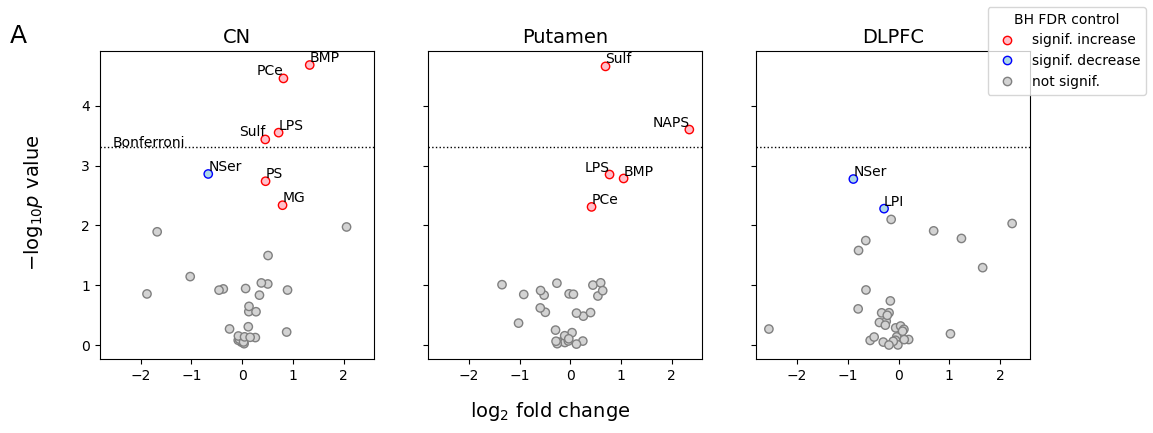

In [41]:
fig, ax = plt.subplots(1, len(brain_regions1), sharey=True, sharex=True, figsize=(12, 4))
horizontalalignment_region = {'CN': {'PCe': 'right', 'Sulf': 'right'}, 'Putamen': {'LPS': 'right', 'NAPS': 'right'}}
for axi, r in zip(ax, brain_regions1):
    axi.scatter(x=log2fold_changes[r], y=-pvalues['log10pvalues'][r], edgecolors=edgecolors[r], marker='o', facecolors=facecolors[r])
    for x, y, s in zip(log2fold_changes[r], -pvalues['log10pvalues'][r], textvec[r]):
        if r in horizontalalignment_region.keys():
            change_alignment = s in horizontalalignment_region[r].keys()
        else:
            change_alignment = False
        horizontalalignment = horizontalalignment_region[r][s] if change_alignment else 'left'
        axi.text(x=x, y=y, s=s, verticalalignment='bottom', horizontalalignment=horizontalalignment)
    bonf_y = -np.log10(pvalues['alphacBonf'])
    axi.axhline(y=bonf_y, linestyle='dotted', color='black', linewidth=1)
    if r == 'CN':
        axi.text(x=log2fold_changes.min(axis=0).min(), y=bonf_y, s=r'Bonferroni')
    axi.set_title(r, fontsize=14)
    #axi.set_xlabel(r'$\log_2$ fold change')
    #axi.set_ylabel(r'$\log_{10}p$ value')

fig.legend(handles=[line2d_legend('red', 'pink', 'signif. increase'),
                    line2d_legend('blue', 'lightblue', 'signif. decrease'),
                    line2d_legend('gray', 'lightgray', 'not signif.'),
                   ], title='BH FDR control')
fig.supxlabel(r'$\log_2$ fold change', y=-0.05, fontsize=14)
fig.supylabel(r'$-\log_{10}p$ value', x=0.06, fontsize=14)
fig.text(0.05, 0.9, 'A', fontsize=18)
attila_utils.savefig(fig, 'volcano-plot-ChAc-Region')

## Tables

Extract parameter estimates and associated $p$-values

In [42]:
def extract_vector_property(fun, effects='mixed', formula='Level ~ 1 + Dx:Region + AgeAtDeath', fittedm=fitted_models):
    s = fittedm.loc[(effects, formula)]
    df = s.apply(fun)
    return(df)

pars = extract_vector_property(lambda x: x.params)
pvals = extract_vector_property(lambda x: x.pvalues)
parest = pd.concat([pars, pvals], axis=1, keys=['estimate', 'p-value'])
parest = parest.swaplevel(i=-2, j=-1, axis=1)
parest = parest.reindex(pd.MultiIndex.from_product([pars.columns, ['estimate', 'p-value']]), axis=1)
fpath = '../../results/2022-09-04-mixed-models/supplementary-tables.xlsx'
with pd.ExcelWriter(fpath) as writer:
    lipid_species.to_excel(writer, sheet_name='Table S1 Lipid levels')
    parest.to_excel(writer, sheet_name='Table S2 Inferred effects')

In [43]:
l = [extract_property(lambda m: m.pvalues.loc['Region[T.' + r +']'])[('species-level data', 'mixed')] for r in brain_regions1[:-1]]
pvalues_region = pd.concat(l, axis=1)
pvalues_region.columns = brain_regions1[:-1]
pvalues_long_region = pvalues_region.unstack()
reject_long_region, pvals_corrected_long_region, alphacSidak_region, alphacBonf_region = sm.stats.multipletests(pvalues_long_region, method='fdr_bh')
reject_region = unstack_corrected(reject_long_region, index=pvalues_long_region.index)
reject = unstack_corrected(pvalues['reject_long'])
fpath = '../../results/2022-09-04-mixed-models/table1-fdr-reject.xlsx'
with pd.ExcelWriter(fpath) as writer:
    pd.concat([reject, reject_region], axis=1).to_excel(writer)

## Estimates and errors

['named-figure/dx-region-estimates.png',
 'named-figure/dx-region-estimates.pdf']

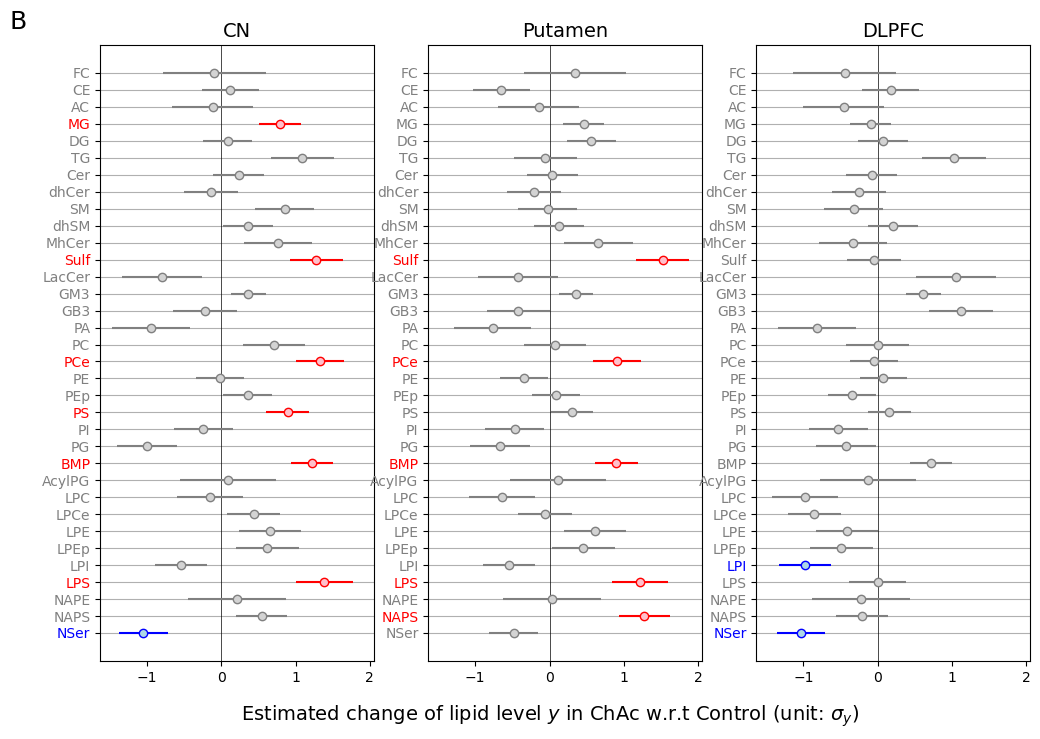

In [44]:
bse = extract_vector_property(lambda x: x.bse)
fig, ax = plt.subplots(1, len(brain_regions1), sharey=False, sharex=True, figsize=(12, 8))
revticks = pd.Series(np.arange(pars.shape[0], 0, -1) - 1, index=pars.index)
fwticks = pd.Series(range(pars.shape[0]), index=pars.index)
for r, axi in zip(brain_regions1, ax):
    axi.set_title(r, fontsize=14)
    axi.axvline(0, linestyle='solid', color='black', linewidth=0.5)
    axi.grid(axis='y')
    axi.set_yticks(revticks)
    axi.set_yticklabels(revticks.index)
    col = 'Dx[T.ChAc]:Region[' + r +']'
    def plot_significance_set(boolv=~reject[r], markeredgecolor='gray', markerfacecolor='lightgray'):
        y = revticks.loc[boolv]
        x_pars = pars.loc[boolv, col]
        xerr = bse.loc[boolv, col]
        axi.errorbar(x=x_pars, y=y, xerr=xerr, linestyle='none', ecolor=markeredgecolor, markeredgecolor=markeredgecolor, markerfacecolor=markerfacecolor, marker='o')
        for ix in fwticks[boolv]:
            axi.get_yticklabels()[ix].set_color(markeredgecolor)
        return(y)
    plot_significance_set(boolv=~reject[r], markeredgecolor='gray', markerfacecolor='lightgray')
    plot_significance_set(boolv=reject[r] & (pars[col] > 0), markeredgecolor='red', markerfacecolor='pink')
    y = plot_significance_set(boolv=reject[r] & (pars[col] < 0), markeredgecolor='blue', markerfacecolor='lightblue')
fig.supxlabel(r'Estimated change of lipid level $y$ in ChAc w.r.t Control (unit: $\sigma_y$)', y=0.025, fontsize=14)
fig.text(0.05, 0.9, 'B', fontsize=18)
attila_utils.savefig(fig, 'dx-region-estimates')

## Goodness of fit: Jarque-Bera test

Here I perform the [Jarque-Bera goodness of fit test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test), which assesses whether the normality assumption of linear modeling holds.  The test results show that
1. the assumption is violated for many data sets and models
1. adding the random effects of individuals improves fit
1. the adding the Dx:Region interaction term substantially improves the fit
1. normality is rejected less confidently (at a greater $p$-value) in the group-level data than in the species-level data

The last point is not surprising when we recall that the group-level data contains fewer points than the species-level data.


In [45]:
#fitted_models.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [46]:
#fitted_groupmodels.applymap(lambda m: sms.jarque_bera(m.resid)[1])

In [47]:
def imshow_model_property(ax, fun, effects='fixed', vmin=-6, vmax=0,
                          cmap='RdYlGn', fitted_models=fitted_models,
                          cb_label=r'$- \log_{10}p$-value', suptitle='Goodness of fit:  Jarque-Bera test'):
    data = fitted_models.xs(effects, level=0, axis=0)
    image = data.applymap(fun)
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('Linear ' + effects + ' effects models')
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(data.columns, rotation=90)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(data.index)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=cb_label)
    fig.suptitle(suptitle, fontsize=14)
    return(ax)

['named-figure/jarque-bera-goodness-of-fit-pval-group-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-group-level.pdf']

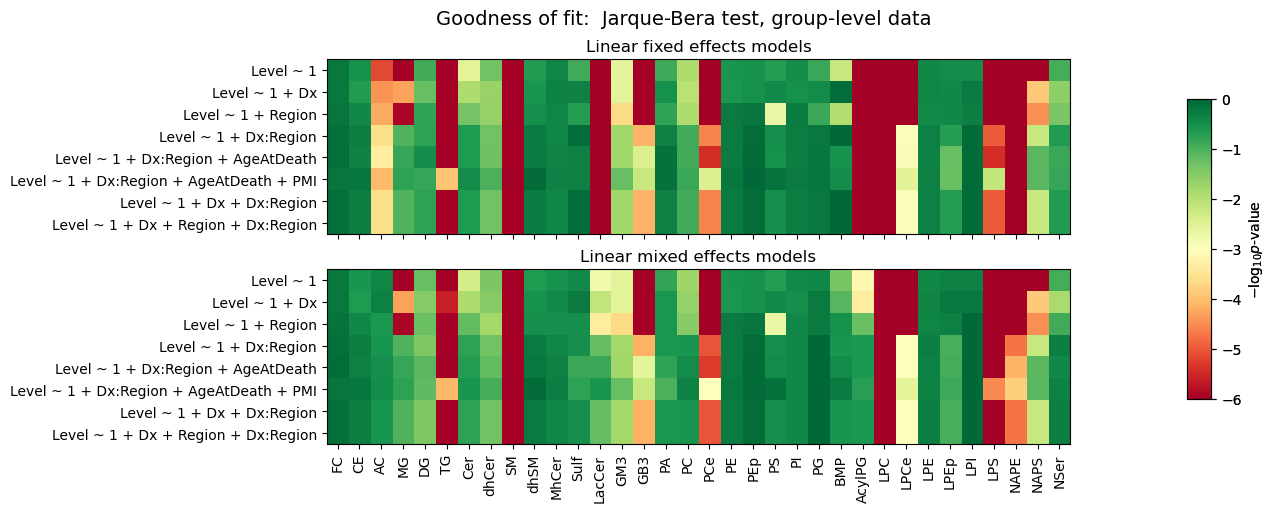

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
suptitle = 'Goodness of fit:  Jarque-Bera test, group-level data'
imshow_model_property(ax[0], fun, 'fixed', suptitle=suptitle, vmin=-6, fitted_models=fitted_groupmodels)
imshow_model_property(ax[1], fun, 'mixed', suptitle=suptitle, vmin=-6, fitted_models=fitted_groupmodels)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-group-level')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_19040/2461073920.py:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_19040/2461073920.py:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_19040/2461073920.py:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_19040/2461073920.py:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_19040/2461073920.py:2: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/i

['named-figure/jarque-bera-goodness-of-fit-pval-species-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-species-level.pdf']

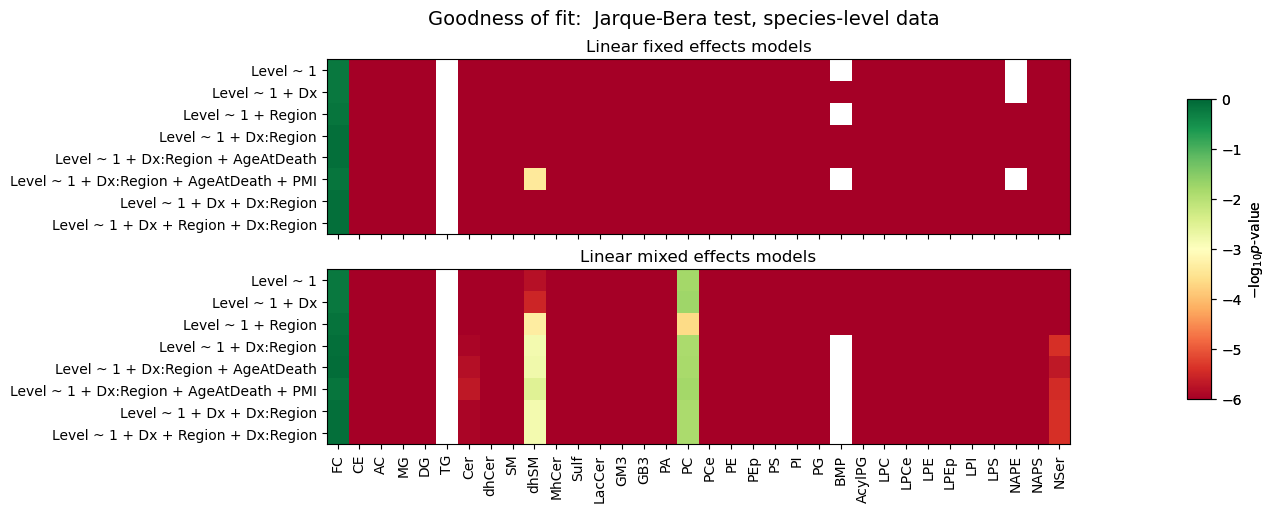

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
suptitle = 'Goodness of fit:  Jarque-Bera test, species-level data'
imshow_model_property(ax[0], fun, 'fixed', suptitle=suptitle, vmin=-6)
imshow_model_property(ax[1], fun, 'mixed', suptitle=suptitle, vmin=-6)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-species-level')

['named-figure/jarque-bera-goodness-of-fit-pval-vs-total-lipid-level.png',
 'named-figure/jarque-bera-goodness-of-fit-pval-vs-total-lipid-level.pdf']

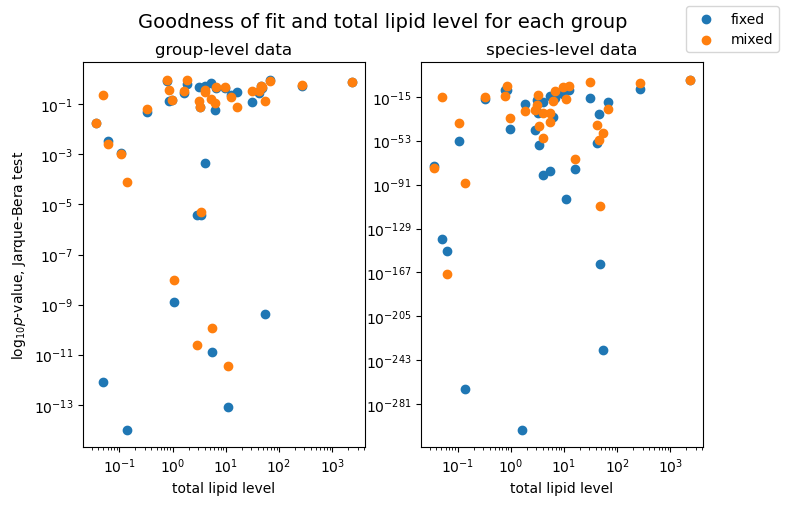

In [50]:
def total_level_vs_jb_pval(ax, fitted=fitted_groupmodels, formula='Level ~ 1 + Dx:Region + AgeAtDeath', do_label=True):
    fun = lambda m: sms.jarque_bera(m.resid)[1]
    df = fitted.xs(formula, level=1, axis=0).applymap(fun)
    effects = effects = np.unique(df.index.get_level_values(0))
    [ax.scatter(x=lipid_groups.sum(axis=1), y=df.loc[fx], marker='o', label=fx if do_label else None) for fx in effects]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('total lipid level')
    

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
total_level_vs_jb_pval(ax[0], fitted=fitted_groupmodels, do_label=False)
ax[0].set_ylabel(r'$\log_{10}p$-value, Jarque-Bera test')
ax[0].set_title('group-level data')
total_level_vs_jb_pval(ax[1], fitted=fitted_models)
ax[1].set_title('species-level data')
fig.legend()
fig.suptitle('Goodness of fit and total lipid level for each group', fontsize=14)
attila_utils.savefig(fig, 'jarque-bera-goodness-of-fit-pval-vs-total-lipid-level')

## Goodness of fit: normal QQ plot of Pearson residuals

Inspecting the distribution of Pearson residuals we see, again, that in most cases they tend to be distributed non-normally for most lipid groups and models.  Further points:
1. the distribution of residuals is right-skewed (whereas the assumption is the unskewed, normal distribution)
1. for a given regression formula the group-level and species level data show similar departure from normality

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


['named-figure/selected-qq-plots-fixed-fx.png',
 'named-figure/selected-qq-plots-fixed-fx.pdf']

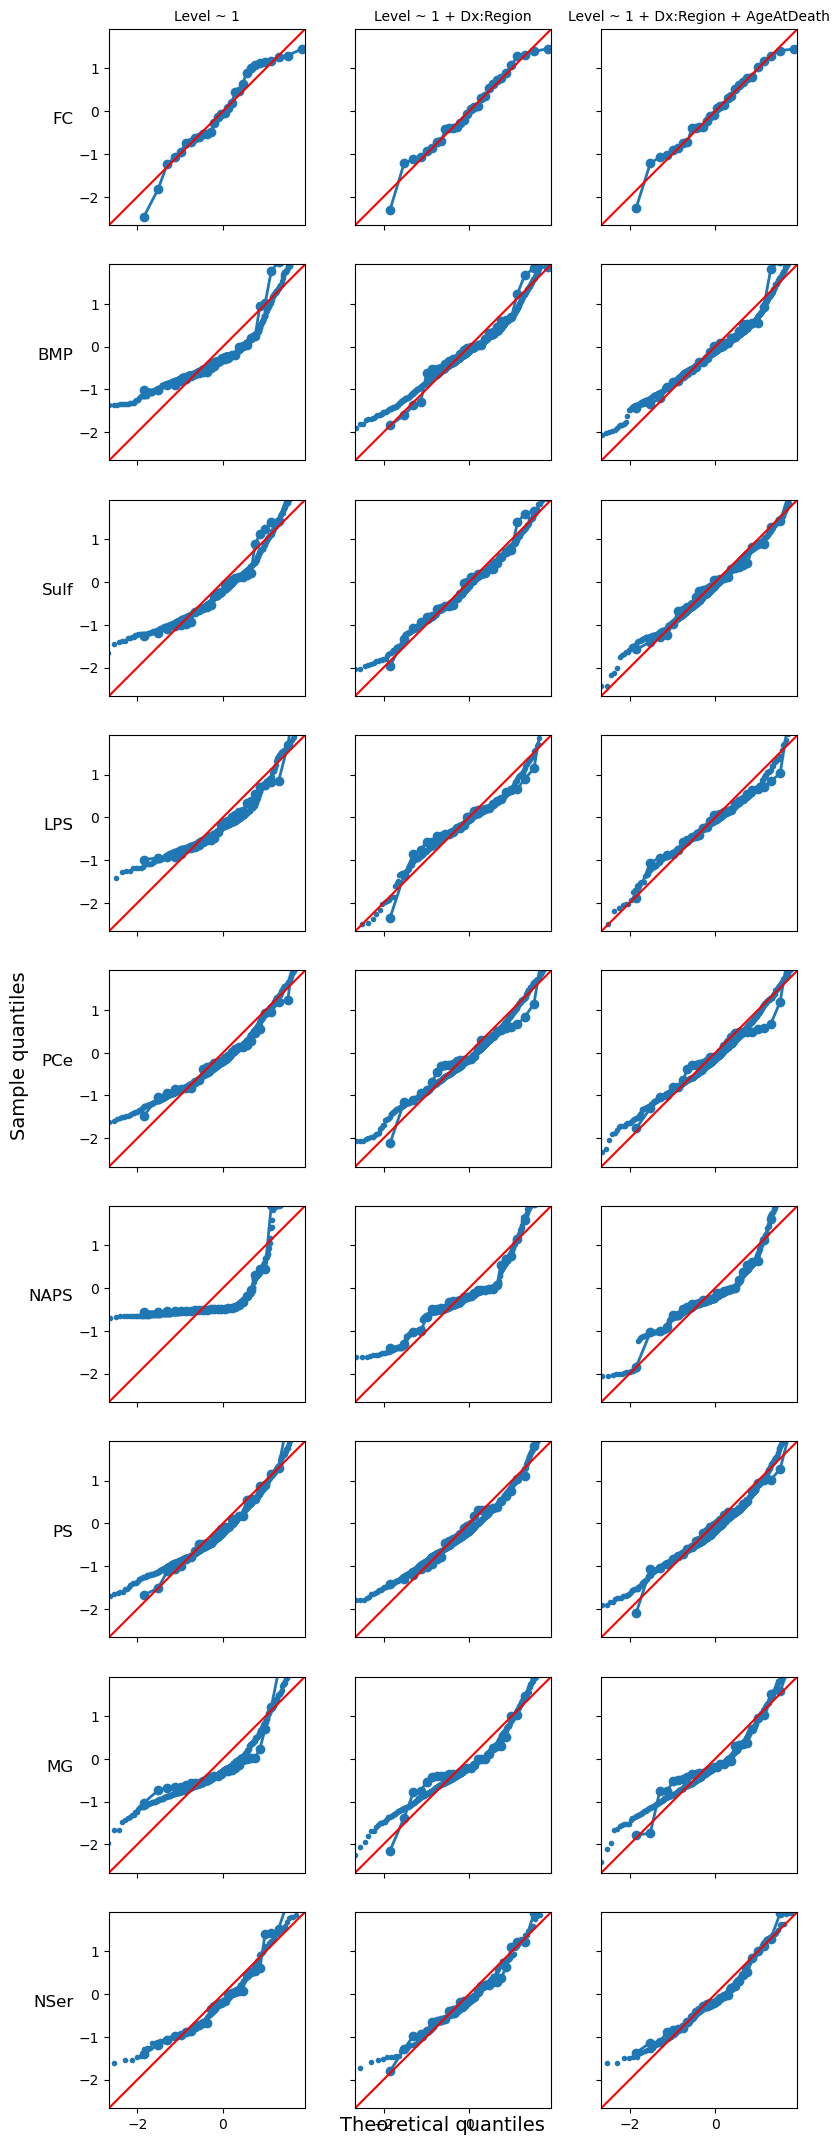

In [51]:
def qqplot_group(ax, group, effects='fixed', do_title=False):
    data = fitted_models[group].xs(effects, axis=0, level=0)
    gdata = fitted_groupmodels[group].xs(effects, axis=0, level=0)
    formulas = data.index[[0, 3, 4]]
    for formula, axi in zip(formulas, ax):
        m = data.loc[formula]
        gm = gdata.loc[formula]
        #sm.qqplot(m.resid, stats.norm, marker='.', ax=axi, line='45')
        sm.qqplot(gm.resid_pearson, stats.norm, marker='o', color='C0', ax=axi, linestyle='solid', linewidth=2)
        sm.qqplot(m.resid_pearson, stats.norm, marker='.', color='C2', ax=axi, line='45', linewidth=1)
        axi.set_xlabel('')
        axi.set_ylabel('')
        axi.set_aspect(1)
        if do_title:
            axi.set_title(formula, rotation=0, fontsize=10)
    ax[0].set_ylabel(group, rotation=0, fontsize=12, horizontalalignment='right')
    gline = Line2D([0, 1], [0, 0], linewidth=2, color='C0', label='group-level data', marker='o')
    line = Line2D([0, 1], [1, 1], linewidth=1, color='C2', label='species-level data', marker='.')
    return(ax)

sel_groups = ['FC', 'BMP', 'Sulf', 'LPS', 'PCe', 'NAPS', 'PS', 'MG', 'NSer']
fig, ax = plt.subplots(len(sel_groups), 3, figsize=(9, 3 * len(sel_groups)), sharey=True, sharex=True)
for g, axi in zip(sel_groups, ax):
    qqplot_group(axi, group=g, effects='fixed', do_title=True if g == 'FC' else False)
fig.supxlabel('Theoretical quantiles', y=0.1, fontsize=14)
fig.supylabel('Sample quantiles', fontsize=14)
attila_utils.savefig(fig, 'selected-qq-plots-fixed-fx')

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


['named-figure/all-qq-plots-fixed-fx.png',
 'named-figure/all-qq-plots-fixed-fx.pdf']

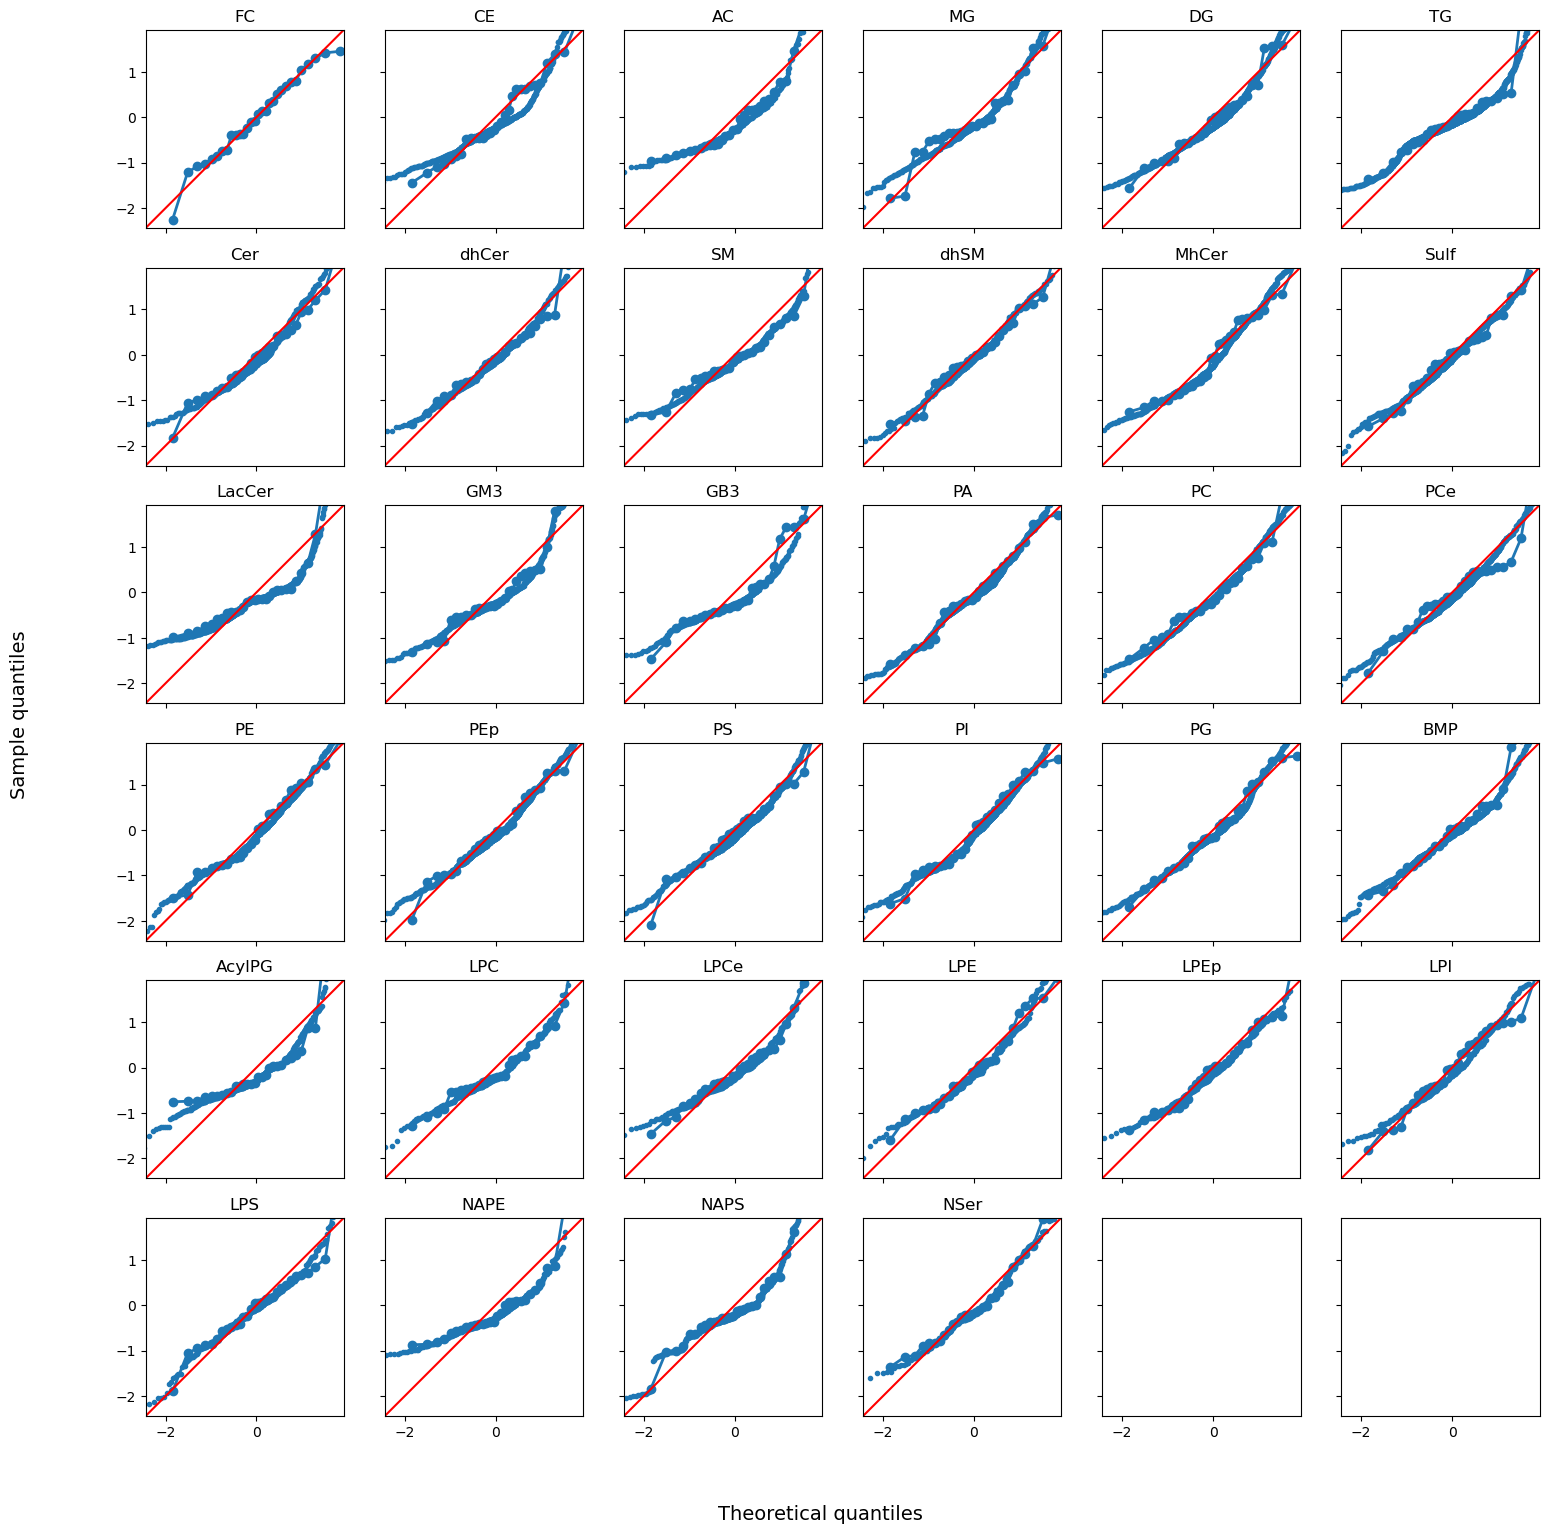

In [52]:
def qqplot_all_group(axi, group, effects='fixed'):
    data = fitted_models[group].xs(effects, axis=0, level=0)
    gdata = fitted_groupmodels[group].xs(effects, axis=0, level=0)
    formula = data.index[4]
    m = data.loc[formula]
    gm = gdata.loc[formula]
    #sm.qqplot(m.resid, stats.norm, marker='.', ax=axi, line='45')
    sm.qqplot(gm.resid_pearson, stats.norm, marker='o', color='C0', ax=axi, linestyle='solid', linewidth=2)
    sm.qqplot(m.resid_pearson, stats.norm, marker='.', color='C2', ax=axi, line='45', linewidth=1)
    axi.set_xlabel('')
    axi.set_ylabel('')
    axi.set_aspect(1)
    axi.set_title(group)
    #ax.set_ylabel(group, rotation=0, fontsize=12, horizontalalignment='right')
    gline = Line2D([0, 1], [0, 0], linewidth=2, color='C0', label='group-level data', marker='o')
    line = Line2D([0, 1], [1, 1], linewidth=1, color='C2', label='species-level data', marker='.')
    return(ax)

sel_groups = ['FC', 'BMP', 'Sulf', 'LPS', 'PCe', 'NAPS', 'PS', 'MG', 'NSer']


fig, ax = plt.subplots(6, 6, figsize=(18, 18), sharey=True, sharex=True)
for ix, group in zip(zip(*np.unravel_index(range(len(lipid_groups.index)), (6, 6))), lipid_groups.index):
    axi = ax[ix]
    qqplot_all_group(axi, group=group, effects='fixed')

fig.supxlabel('Theoretical quantiles', y=0.05, fontsize=14)
fig.supylabel('Sample quantiles', x=0.05, fontsize=14)
attila_utils.savefig(fig, 'all-qq-plots-fixed-fx')

In [53]:
%connect_info

{
  "shell_port": 57227,
  "iopub_port": 57228,
  "stdin_port": 57229,
  "control_port": 57231,
  "hb_port": 57230,
  "ip": "127.0.0.1",
  "key": "2a36cdd6-6fae09d5b1e067e5a758d690",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-64ff47cd-239c-4f86-bf91-2f7f871fb30b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
